# Brain Tumour Classification using InceptionV3 (Transfer Learning)

This notebook demonstrates the use of the **InceptionV3** architecture, pre-trained on ImageNet, for the classification of brain tumour MRI images into four categories.

## 🔍 Objective:
- Preprocess and augment brain MRI images.
- Leverage transfer learning with InceptionV3.
- Train and fine-tune the model.
- Evaluate the performance using metrics and visualisations.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset directories
train_dir = "C:/Users/abdul/OneDrive/Desktop/Machine Learning/PEC/brain_tumor_dataset/Training"
test_dir = "C:/Users/abdul/OneDrive/Desktop/Machine Learning/PEC/brain_tumor_dataset/Testing"

# Create ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values 
)

# Load training data with augmentation
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # Match ResNet input size
    batch_size=32,
    class_mode='sparse',  # Multi-class classification
    subset='training'
)


# Load test data separately (no validation split)
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Print dataset details
print("Classes:", train_data.class_indices)
import numpy as np

# Print first 5 labels from the dataset
print("Sample Labels:", train_data.classes[:5])
print("Label Shape:", train_data.labels.shape)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Sample Labels: [0 0 0 0 0]
Label Shape: (5712,)


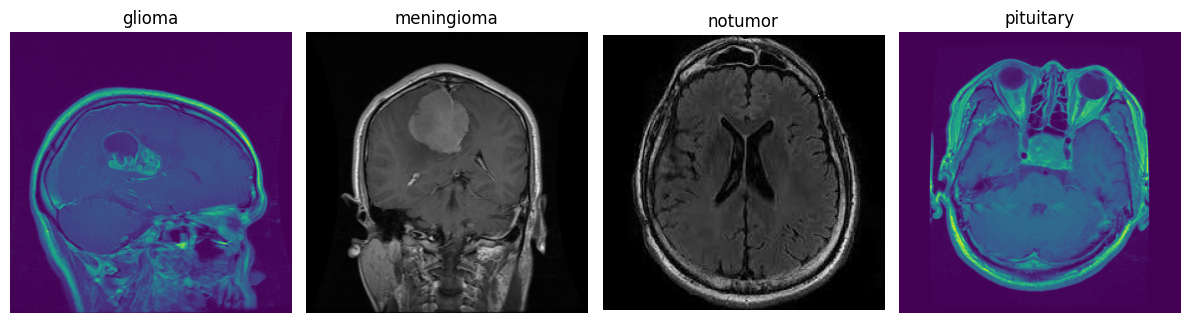

In [4]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
def show_random_images(directory, class_names):
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        random_img = random.choice(os.listdir(class_path))
        img = Image.open(os.path.join(class_path, random_img))
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display 1 random image from each class in training set
show_random_images(train_dir, list(train_data.class_indices.keys()))


In [5]:

from tensorflow.keras.applications import InceptionV3, ResNet50, vgg16, Xception, MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

# Define Learning Rate Schedule
def lr_schedule(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        return lr * 0.5  # Reduce LR by half every 6 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)


#  Load Pretrained InceptionV3 Model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

#  Freeze all but the last few layers for fine-tuning
for layer in base_model.layers[:-16]:  
    layer.trainable = False  # Only fine-tune last 16 layers

#  Add custom layers after base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Helps reduce shape mismatch errors
x = Dense(4, activation="softmax")(x)  # Multi-class classification

# #  Create final model
model = Model(inputs=base_model.input, outputs=x)

# #  Compile model
model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# #  Define callbacks
tensorboard = TensorBoard(log_dir='./InceptionV3_logs', histogram_freq=0, write_graph=True, write_images=False)
# early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1)


### If You Want to train your own Model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D(2, 2),
    
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
    
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
    
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(4, activation='softmax')  # 4 classes
# ])
# model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# # # Print Model Summary
model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 149, 149, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 149, 149, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 147, 147, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 147, 147, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 73, 73, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 71, 71, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 403,460 (1.54 MB)

 Non-trainable params: 21,407,520 (81.66 MB)

In [4]:
history = model.fit(train_data, epochs=10, validation_data=test_data, callbacks=[ lr_scheduler, tensorboard])


C:\Users\abdul\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.8195 - loss: 0.4585 - val_accuracy: 0.9031 - val_loss: 0.2964 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - accuracy: 0.9544 - loss: 0.1369 - val_accuracy: 0.9504 - val_loss: 0.1434 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.9750 - loss: 0.0813 - val_accuracy: 0.9672 - val_loss: 0.1003 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3584s 20s/step - accuracy: 0.9792 - loss: 0.0606 - val_accuracy: 0.9756 - val_loss: 0.0757 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000

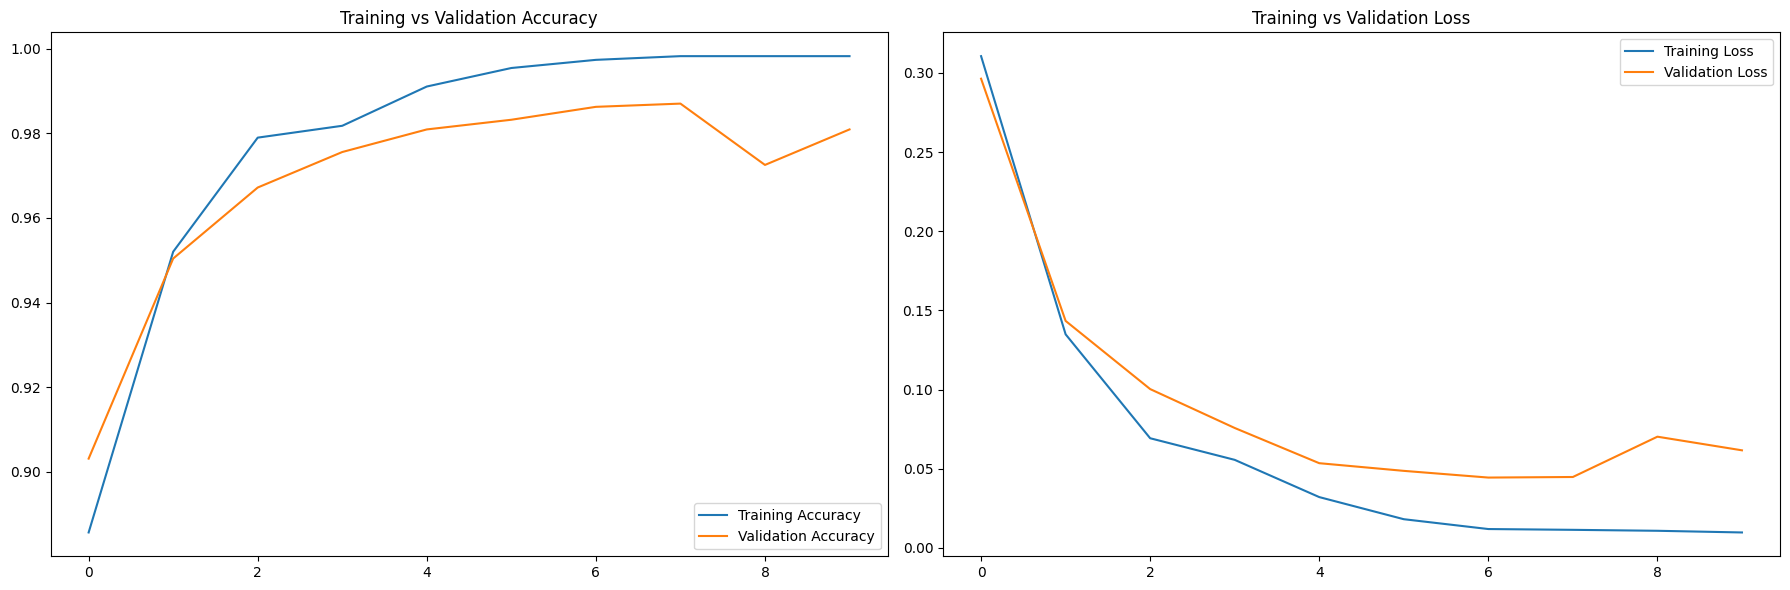

In [6]:

import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

#  1. Accuracy & Loss Plot
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(18, 6))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
    
    plt.legend(loc='lower right')
    plt.title('Training vs Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs Validation Loss')
    plt.tight_layout()
    plt.show()

#  Call function to plot graphs
plot_training(history)



41/41 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       300
  meningioma       0.94      0.99      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



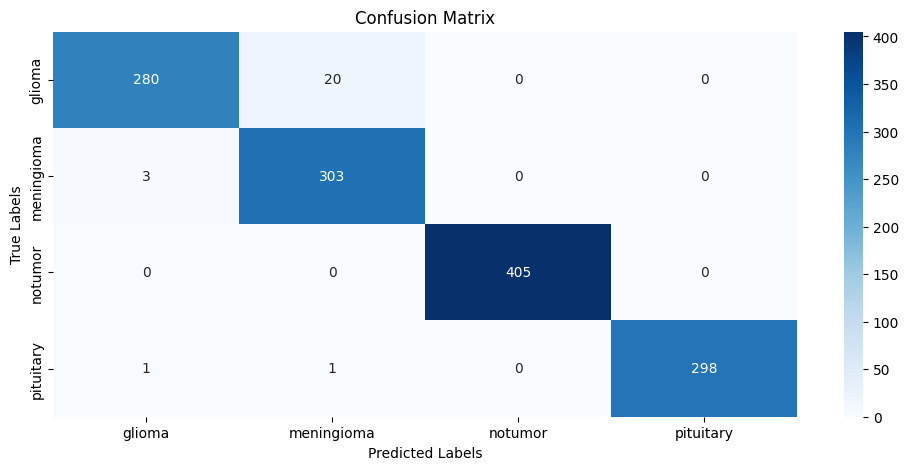

In [7]:
#  2. Classification Report & Confusion Matrix
# Get predictions
y_true = test_data.classes  # Actual labels
y_pred = np.argmax(model.predict(test_data), axis=1)  # Predicted labels

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(test_data.class_indices.keys()), yticklabels=list(test_data.class_indices.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step


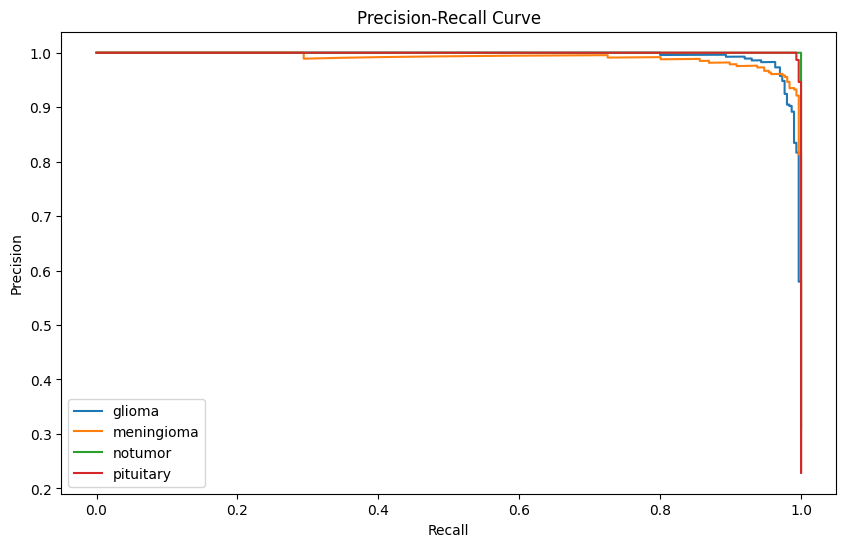

In [8]:
#  3. Precision-Recall Curve
y_probs = model.predict(test_data)  # Get model probabilities

plt.figure(figsize=(10, 6))
for i, class_name in enumerate(test_data.class_indices.keys()):
    precision, recall, _ = precision_recall_curve(y_true == i, y_probs[:, i])
    plt.plot(recall, precision, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

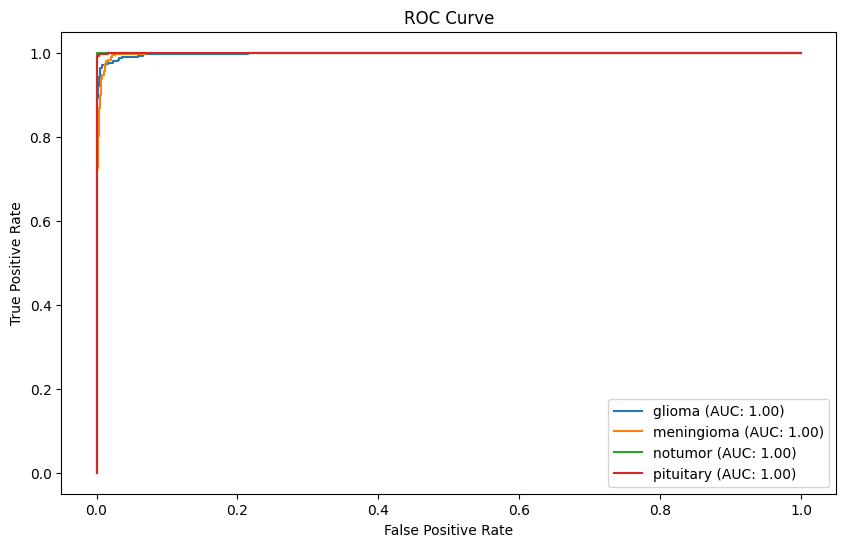

In [9]:
#  4. ROC Curve
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(test_data.class_indices.keys()):
    fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC: {auc(fpr, tpr):.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [10]:
#  5. Per-Class Accuracy
correct_preds = np.equal(y_true, y_pred)  # Compare true vs predicted
class_acc = [correct_preds[y_true == i].mean() for i in range(len(test_data.class_indices))]

for class_name, acc in zip(test_data.class_indices.keys(), class_acc):
    print(f"Accuracy for {class_name}: {acc:.2%}")


#  6. Model Parameter Breakdown
trainable_params = sum([np.prod(w.shape) for layer in model.layers if layer.trainable for w in layer.trainable_weights])
non_trainable_params = sum([np.prod(w.shape) for layer in model.layers if not layer.trainable for w in layer.non_trainable_weights])

print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")


Accuracy for glioma: 93.33%
Accuracy for meningioma: 99.02%
Accuracy for notumor: 100.00%
Accuracy for pituitary: 99.33%
Trainable Parameters: 403460
Non-Trainable Parameters: 21403424


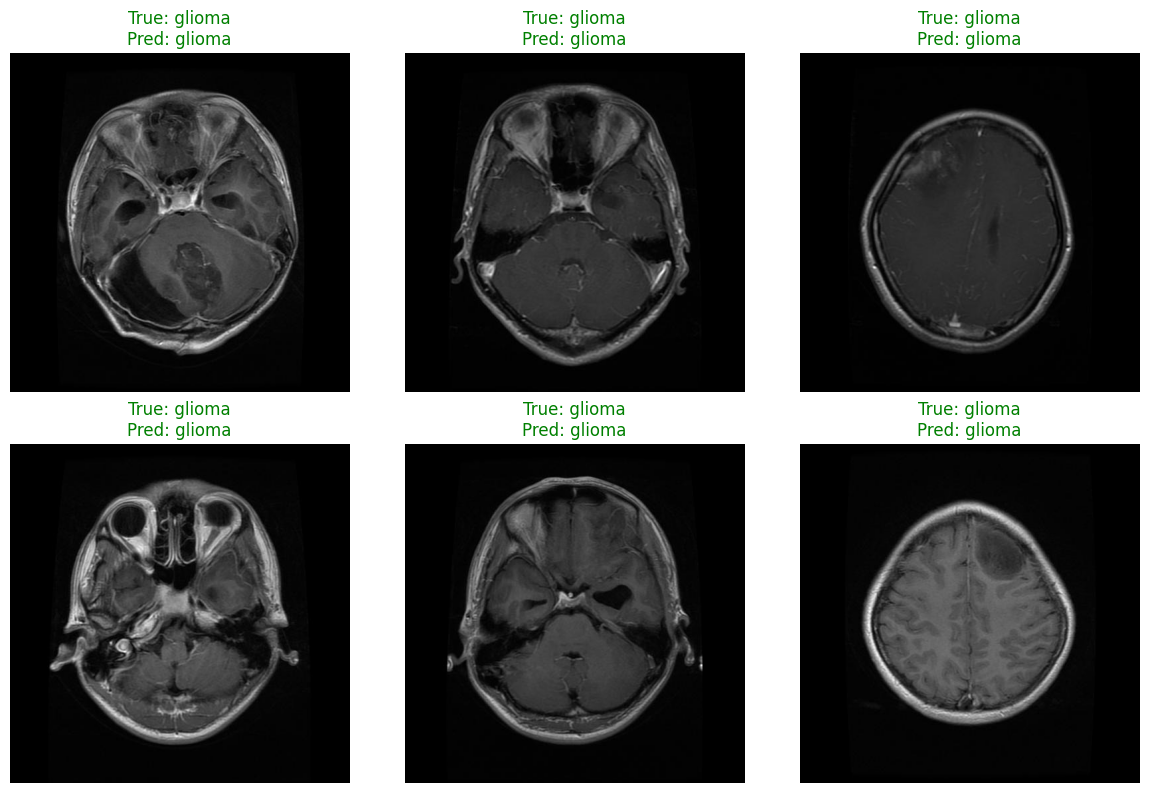

In [18]:
import os  

# Get filenames and predictions
filenames = test_data.filenames
predictions = y_pred

# Show 6 sample predictions
plt.figure(figsize=(12, 8))
for i in range(6):
    img_path = os.path.join(test_dir, filenames[i])
    img = Image.open(img_path)
    plt.subplot(2, 3, i+1)
    true_label = list(test_data.class_indices.keys())[y_true[i]]
    pred_label = list(test_data.class_indices.keys())[predictions[i]]
    colour = 'green' if true_label == pred_label else 'red'
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=colour)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [19]:
model.save("modelF.keras")


In [20]:
# Save model in HDF5 format (.h5)
model.save("brain_tumor_modelF.h5", save_format="h5")

## ✅ Final Thoughts

- The model shows strong generalisation across test data with high accuracy.
- Confusion matrix and classification report indicate reliable performance across all four tumour classes.
- With further data and fine-tuning, the model can be deployed in clinical support systems.

### ⚡ Possible Improvements
- Implement cross-validation for more robust evaluation.
- Experiment with different architectures like EfficientNet or Xception.
- Apply Grad-CAM for visualising model attention on MRI images.
